In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import re

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import tensorflow as tf

In [3]:
from keras.models import load_model
model = load_model('model.h5')

OSError: Unable to open file (unable to open file: name = 'model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [6]:
df = pd.read_csv('C:/Users/Admin/Desktop/Healthhack/export.csv')
df.head()
print(1/(len(df[df['benign_malignant']=='malignant'])/len(df[df['benign_malignant']=='benign'])))

15.45353675450763


In [7]:
df.head()
directory = 'C:/Users/Admin/Desktop/Healthhack/ISIC-Archive-Downloader-master/Data/Images/'
def filepath(x):
    return str(directory+x+".jpeg")
df['path'] = df['filename'].apply(filepath)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
df.head()

,filename,benign_malignant,path,image
0,ISIC_0000000,benign,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[132, 171, 226], [146, 188, 246], [146, 197,..."
1,ISIC_0000001,benign,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[131, 130, 138], [128, 127, 135], [135, 132,..."
2,ISIC_0000002,malignant,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[14, 14, 14], [4, 4, 4], [3, 3, 3], [3, 3, 3..."
3,ISIC_0000003,benign,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[224, 223, 229], [224, 223, 229], [223, 223,..."
4,ISIC_0000004,malignant,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[10, 10, 10], [0, 0, 0], [0, 0, 0], [0, 0, 0..."


In [8]:
df=df.dropna().sort_values("benign_malignant")

def change_cat(x):
    if x == 'malignant':
        return 1
    else:
        return 0
df['cat'] = df['benign_malignant'].apply(change_cat)
df.tail()

,filename,benign_malignant,path,image,cat
11166,ISIC_0011166,malignant,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[154, 112, 96], [151, 97, 87], [158, 111, 10...",1
11169,ISIC_0011169,malignant,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[168, 156, 130], [170, 156, 130], [171, 155,...",1
469,ISIC_0000469,malignant,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[166, 149, 141], [164, 149, 142], [162, 147,...",1
11176,ISIC_0011176,malignant,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[198, 187, 169], [202, 189, 172], [203, 188,...",1
10140,ISIC_0010140,malignant,C:/Users/Admin/Desktop/Healthhack/ISIC-Archive...,"[[[196, 191, 172], [197, 186, 164], [196, 178,...",1


In [9]:
df_test = df.copy()
malignant = df_test[df_test['benign_malignant']== 'malignant']
benign = df_test[df_test['benign_malignant']== 'benign']

In [11]:
df_repeated = pd.concat([malignant] * 15, ignore_index=True)

In [12]:
df_test = pd.concat([df_repeated,benign], ignore_index=True)


In [13]:
print(1/(len(df_test[df_test['benign_malignant']=='malignant'])/len(df_test[df_test['benign_malignant']=='benign'])))

1.0302357836338418


In [14]:
features=df_test['image']
target=df_test['cat']

In [15]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

#### Normalisation

In [16]:
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())

In [17]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [21]:
print(x_train_mean)
print(x_train_std)

151.2802221463137
49.41325356259786


In [22]:
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

### Splitting and validating split

In [23]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [24]:
x_train.shape[0]

15808

In [25]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [26]:
x_train.shape

(15808, 75, 100, 3)

In [27]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 2

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [28]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [29]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [31]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [32]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1580/1580 [==============================] - 616s 390ms/step - loss: 0.3683 - acc: 0.8568 - val_loss: 0.2521 - val_acc: 0.9078
Epoch 2/50
 224/1580 [===>..........................] - ETA: 8:34 - loss: 0.2878 - acc: 0.8951

KeyboardInterrupt: 

In [33]:
from keras.models import load_model


model = load_model('model_balanced.h5')

In [34]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model_balanced.h5")

1757/1757 [==============================] - 18s 10ms/step
Validation: accuracy = 0.936824  ;  loss_v = 0.158807
Test: accuracy = 0.939208  ;  loss = 0.180097


In [35]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Utility functions for reading/writing graphs."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import os.path

from google.protobuf import text_format
from tensorflow.python.framework import ops
from tensorflow.python.lib.io import file_io
from tensorflow.python.util.tf_export import tf_export


@tf_export('io.write_graph', v1=['io.write_graph', 'train.write_graph'])
def write_graph(graph_or_graph_def, logdir, name, as_text=True):
  """Writes a graph proto to a file.
  The graph is written as a text proto unless `as_text` is `False`.
  ```python
  v = tf.Variable(0, name='my_variable')
  sess = tf.Session()
  tf.train.write_graph(sess.graph_def, '/tmp/my-model', 'train.pbtxt')
  ```
  or
  ```python
  v = tf.Variable(0, name='my_variable')
  sess = tf.Session()
  tf.train.write_graph(sess.graph, '/tmp/my-model', 'train.pbtxt')
  ```
  Args:
    graph_or_graph_def: A `Graph` or a `GraphDef` protocol buffer.
    logdir: Directory where to write the graph. This can refer to remote
      filesystems, such as Google Cloud Storage (GCS).
    name: Filename for the graph.
    as_text: If `True`, writes the graph as an ASCII proto.
  Returns:
    The path of the output proto file.
  """
  if isinstance(graph_or_graph_def, ops.Graph):
    graph_def = graph_or_graph_def.as_graph_def()
  else:
    graph_def = graph_or_graph_def

  # gcs does not have the concept of directory at the moment.
  if not file_io.file_exists(logdir) and not logdir.startswith('gs:'):
    file_io.recursive_create_dir(logdir)
  path = os.path.join(logdir, name)
  if as_text:
    file_io.atomic_write_string_to_file(path,
                                        text_format.MessageToString(graph_def))
  else:
    file_io.atomic_write_string_to_file(path, graph_def.SerializeToString())
  return path

In [36]:
v = tf.Variable(0, name='my_variable')
sess = tf.Session()
tf.io.write_graph(sess.graph_def, 'C:/Users/Admin', 'train.pbtxt')

'C:/Users/Admin\\train.pbtxt'

In [37]:
plot_model_history(history)

NameError: name 'history' is not defined

428.0


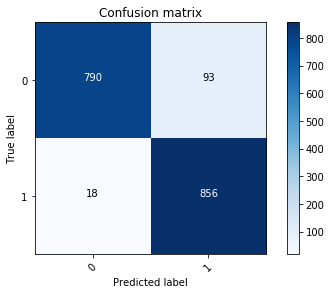

In [41]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

auroc is:0.9370411355090172


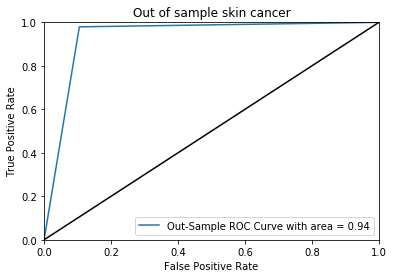

In [45]:
# Trying to include AUROC
(fpr, tpr, thresholds) = roc_curve(Y_true,Y_pred_classes)

area = auc(fpr,tpr)
print("auroc is:" + str(area))
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out of sample skin cancer')
plt.legend(loc="lower right")
plt.show()